Bayesian Statistics Made Simple
===

Code and exercises from my workshop on Bayesian statistics in Python.

Copyright 2018 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

from thinkbayes2 import Suite
import thinkplot

import warnings
warnings.filterwarnings('ignore')

## The likelihood function


Here's a definition for `Bandit`, which extends `Suite` and defines a likelihood function that computes the probability of the data (win or lose) for a given value of `x` (the probability of win).

Note that `hypo` is in the range 0 to 100.

In [2]:
class Bandit(Suite):
    
    def Likelihood(self, data, hypo):
        """ 
        hypo is the prob of win (0-100)
        data is a string, either 'W' or 'L'
        """
        x = hypo / 100
        if data == 'W':
            return x
        else:
            return 1-x

We'll start with a uniform distribution from 0 to 100.

No handles with labels found to put in legend.


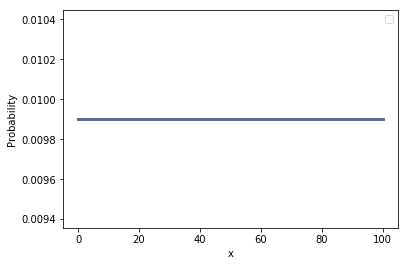

In [3]:
bandit = Bandit(range(101))
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')

Now we can update with a single loss:

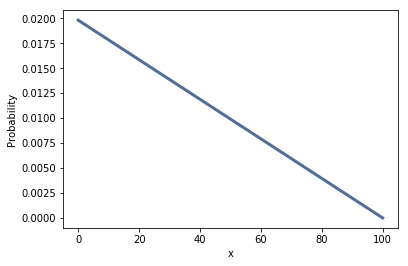

In [4]:
bandit.Update('L')
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability', legend=False)

Another loss:

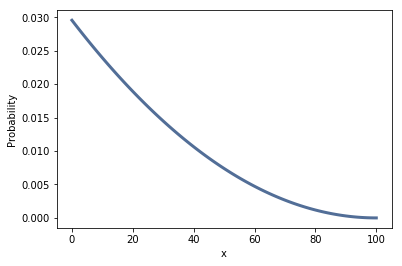

In [5]:
bandit.Update('L')
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability', legend=False)

And a win:

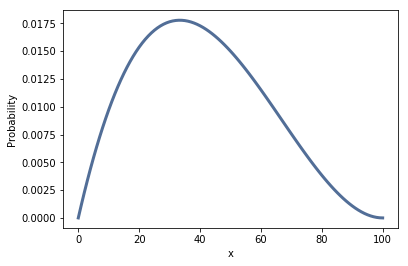

In [6]:
bandit.Update('W')
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability', legend=False)

Starting over, here's what it looks like after 1 win and 9 losses.

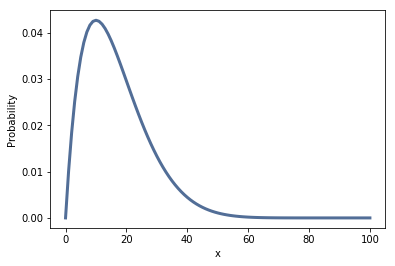

In [7]:
bandit = Bandit(range(101))

for outcome in 'WLLLLLLLLL':
    bandit.Update(outcome)

thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability', legend=False)

The posterior mean is about 17%

In [8]:
bandit.Mean()

16.681944698849055

The most likely value is the observed proportion 1/10

In [9]:
bandit.MAP()

10

The posterior credible interval has a 90% chance of containing the true value (provided that the prior distribution truly represents our background knowledge).

In [10]:
bandit.CredibleInterval(90)

(3, 36)

## Multiple bandits

Now suppose we have several bandits and we want to decide which one to play.

For this example, we have 4 machines with these probabilities:

In [11]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

The following function simulates playing one machine once.

In [12]:
from random import random
from collections import Counter

counter = Counter()

def flip(p):
    return random() < p

def play(i):
    counter[i] += 1
    p = actual_probs[i]
    if flip(p):
        return 'W'
    else:
        return 'L'

Here's a test, playing machine 3 twenty times:

In [13]:
for i in range(20):
    result = play(3)
    print(result, end=' ')

L W W W W L W L W L W L L W L L L W L L 

Now I'll make 4 `Bandit` objects to represent our beliefs about the 4 machines.

In [14]:
prior = range(101)
beliefs = [Bandit(prior) for i in range(4)]

This function displays the four posterior distributions

In [15]:
options = dict(yticklabels='invisible')

def plot(beliefs, **options):
    thinkplot.preplot(rows=2, cols=2)
    for i, b in enumerate(beliefs):
        thinkplot.subplot(i+1)
        thinkplot.Pdf(b, label=i)
        thinkplot.Config(**options)

/home/cgirard/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


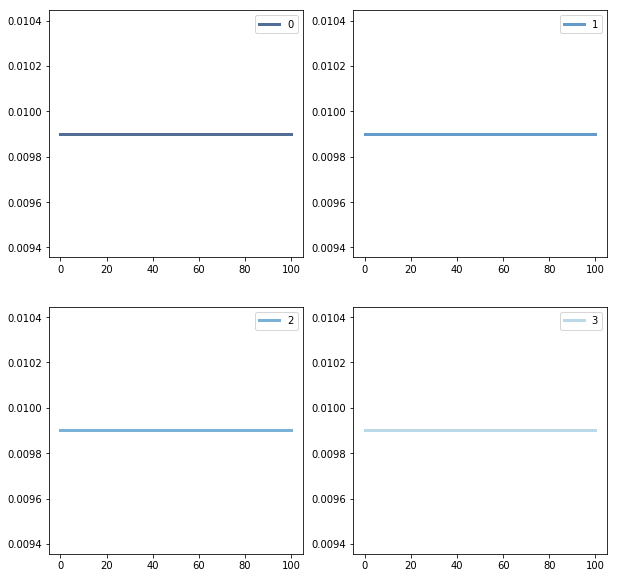

In [16]:
plot(beliefs, legend=True)

Now suppose we play each machine 10 times.  This function updates our beliefs about one of the machines based on one outcome.

In [17]:
def update(beliefs, i, outcome):
    beliefs[i].Update(outcome)

In [18]:
for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(beliefs, i, outcome)

/home/cgirard/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


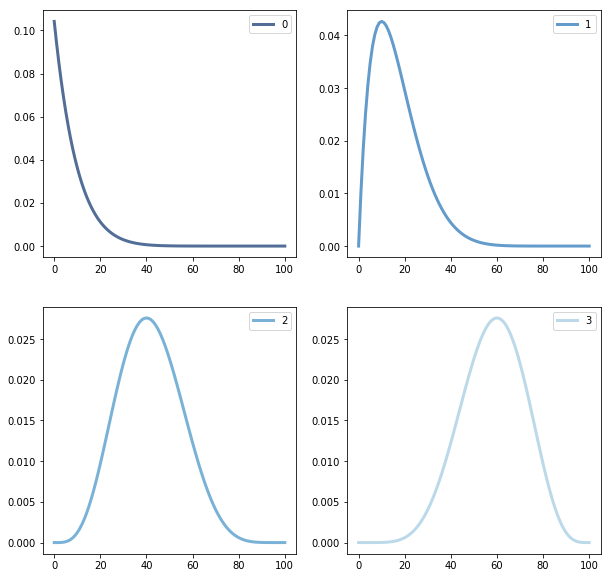

In [19]:
plot(beliefs, legend=True)

After playing each machine 10 times, we have some information about their probabilies:

In [20]:
[belief.Mean() for belief in beliefs]

[7.883360420960963, 16.681944698849055, 41.66666666346025, 58.33333333653976]

## Bayesian Bandits

To get more information, we could play each machine 100 times, but while we are gathering data, we are not making good use of it.  The kernel of the Bayesian Bandits algorithm is that is collects and uses data at the same time.  In other words, it balances exploration and exploitation.

The following function chooses among the machines so that the probability of choosing each machine is proportional to its "probability of superiority".

`Random` chooses a value from the posterior distribution.

`argmax` returns the index of the machine that chose the highest value.

In [21]:
def choose(beliefs):
    ps = [b.Random() for b in beliefs]
    return np.argmax(ps)

Here's an example.

In [22]:
choose(beliefs)

3

Putting it all together, the following function chooses a machine, plays once, and updates `beliefs`:

In [23]:
def choose_play_update(beliefs, verbose=False):
    i = choose(beliefs)
    outcome = play(i)
    update(beliefs, i, outcome)
    if verbose:
        print(i, outcome, beliefs[i].Mean())

Here's an example

In [24]:
counter = Counter()
choose_play_update(beliefs, verbose=True)

3 L 53.8461538451423


## Trying it out

Let's start again with a fresh set of machines:

In [25]:
beliefs = [Bandit(prior) for i in range(4)]

Now we can play a few times and see how `beliefs` gets updated:

/home/cgirard/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


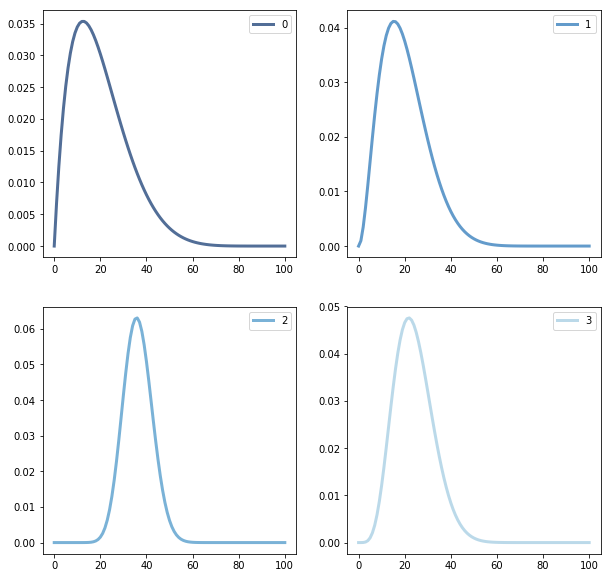

In [26]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

We can summarize `beliefs` by printing the posterior mean and credible interval:

In [27]:
for i, b in enumerate(beliefs):
    print(b.Mean(), b.CredibleInterval(90))

20.01200047997597 (4, 43)
20.00002908191496 (6, 39)
36.20689655172416 (26, 47)
24.000000075080187 (12, 39)


The credible intervals usually contain the true values (10, 20, 30, and 40).

The estimates are still rough, especially for the lower-probability machines.  But that's a feature, not a bug: the goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

Let's see how many times each machine got played.  If things go according to play, the machines with higher probabilities should get played more often.

In [28]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 8
1 13
2 56
3 24


**Exercise:**  Go back and run this section again with a different value of `num_play` and see how it does.